In [1]:
import torch
import numpy as np
from load_brats_sampler import load_data
import matplotlib.pyplot as plt

In [2]:
data_dir = '/srv/Data/playground_data/brats/brats_training_data/data_raw'
h5_path = '/srv/Data/playground_data/brats/h5_t1_t2'
class_cond = False

In [3]:
dataset = load_data(brats_path=data_dir,h5_path=h5_path)
loader = torch.utils.data.DataLoader(dataset,batch_size = 1,shuffle = True ,num_workers= 1)

/home/arunima/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


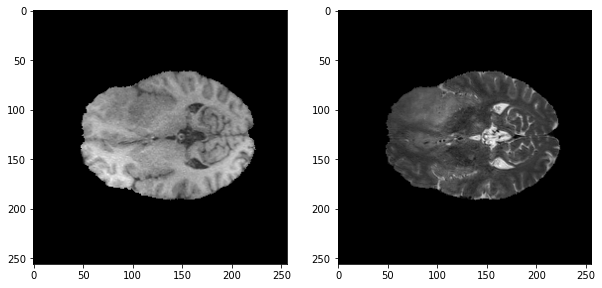

In [4]:
for idx,image in enumerate(loader):
    t1 = image['image_t1']
    t2 = image['image_t2']
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(1,2,1)
    plt.imshow(t1.squeeze(),cmap = 'gray')
    fig.add_subplot(1,2,2)
    plt.imshow(t2.squeeze(),cmap = 'gray')
    break

In [5]:
def coeff(t):
    beta_start = 0.0001
    beta_end = 0.02
    betas = np.linspace(beta_start,beta_end,1000)
    alpha = 1-betas
    
    val = 1
    for i in range(t):
        val *= alpha[t]
    return np.sqrt(val),np.sqrt(1-val),alpha,betas

    

In [6]:
def forward_pass(x_0,t): #### q_sample
    sqrt_alpha_t_bar,sqrt_1alpha_t_bar,_,_ = coeff(t)
    z = torch.rand(x_0.shape)
    x_t = x_0*sqrt_alpha_t_bar + sqrt_1alpha_t_bar*z
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(1,2,1)
    plt.imshow(x_t.squeeze(), cmap = 'gray')
    fig.add_subplot(1,2,2)
    plt.imshow(z.squeeze(), cmap = 'gray')
    return x_t,z

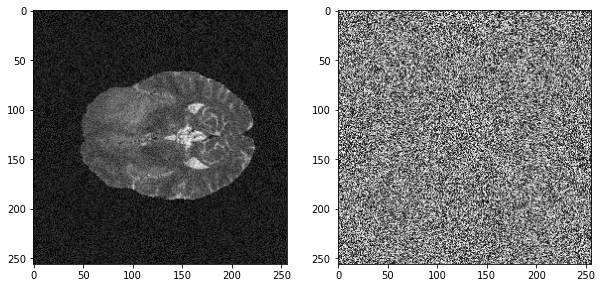

In [7]:
t =50
x_t,z_true= forward_pass(t2,t)


In [8]:
model_path = '/srv/Data/playground_data/checkpoint_folder/model_T1T2_unconditional/Brats-2023-01-20/ema_0.9999_550000.pt'

In [9]:
learn_sigma = True
attention_resolutions = "16,8"
attention_ds = []
for res in attention_resolutions.split(","):
        attention_ds.append(256 // int(res))

from unet_dummy import UNetModel
unet = UNetModel(
        image_size=256,
        in_channels=1,
        model_channels=128,
        out_channels=(1 if not learn_sigma else 2),
        num_res_blocks=3,
        attention_resolutions=tuple(attention_ds),
        dropout=0.1,
        channel_mult=(1, 1, 2, 2, 4, 4),
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=4,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False)

In [10]:
unet.load_state_dict(torch.load(model_path))

/home/arunima/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:104: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


<All keys matched successfully>

In [11]:
timesteps= torch.tensor([t] * 1)
out,hinp,hmid,hout= unet(t2,timesteps)
out.shape  #### The embedding emb is of size [1,512]

torch.Size([1, 2, 256, 256])

### output from input block, there are 512 8*8 feature maps

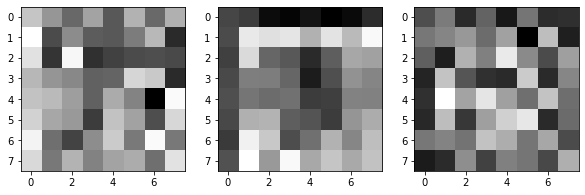

In [12]:
h1=hinp.cpu().detach()
h1.requires_grad = False
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1)
plt.imshow(h1[0,0,:,:].squeeze().cpu().numpy(),cmap ='gray')
fig.add_subplot(1,3,2)
plt.imshow(h1[0,100,:,:].squeeze().cpu().numpy(),cmap ='gray')
fig.add_subplot(1,3,3)
plt.imshow(h1[0,500,:,:].squeeze().cpu().numpy(),cmap ='gray')

### output from middle block, there are 512 8*8 feature maps

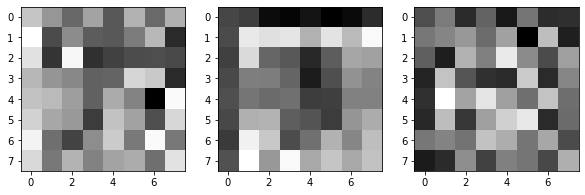

In [13]:
h2=hmid.cpu().detach()
h2.requires_grad = False
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1)
plt.imshow(h2[0,0,:,:].squeeze().cpu().numpy(),cmap ='gray')
fig.add_subplot(1,3,2)
plt.imshow(h2[0,100,:,:].squeeze().cpu().numpy(),cmap ='gray')
fig.add_subplot(1,3,3)
plt.imshow(h2[0,500,:,:].squeeze().cpu().numpy(),cmap ='gray')

### output from decoder block, there are 128  256*256 images

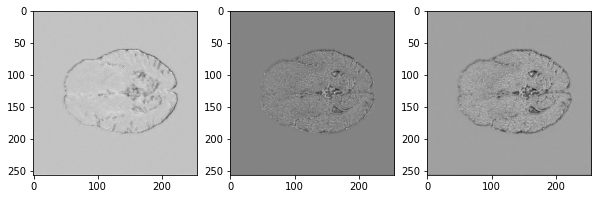

In [14]:
h3=hout.cpu().detach()
h3.requires_grad = False
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1)
plt.imshow(h3[0,0,:,:].squeeze().cpu().numpy(),cmap ='gray')
fig.add_subplot(1,3,2)
plt.imshow(h3[0,70,:,:].squeeze().cpu().numpy(),cmap ='gray')
fig.add_subplot(1,3,3)
plt.imshow(h3[0,120,:,:].squeeze().cpu().numpy(),cmap ='gray')

In [15]:
b,c = t2.shape[:2]
ep,var = torch.split(out,c,dim=1)
err = ep-z_true
x = ep.data
x.requires_grad = False

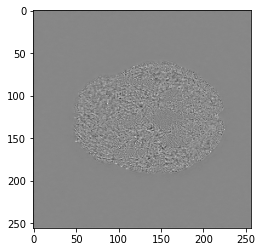

In [16]:
plt.imshow(x.squeeze().cpu().numpy(),cmap ='gray') #### The outout of the model does have semantic information,
                                                   #### its not purely noise!.

In [17]:
# timesteps= torch.tensor([t] * 1)
# out1,emb= unet(t2,timesteps)


Resblock:
>They are incorporating the embeddidng in the Resblock. If scale shift norm is true(which it is) then it pass the emb vector to SiLU then a linear layer and that is chunked into two pieces along dim = 1, then they are normaliing h(output from in_layers), multiplying one part of the chunk embedding with it and adding it to another chunk and finally pasing it through the rest of the out_layers.\
Otherwise,\
>They simply add the o/p of input and emb block and pass it through output layers. 
>Then a skip connection 

Input_blocks

1. Module 0: TimestepEmbedSequential- that implements a conv2d(1,128)
2. Module 1 = Resblock
3. Module 2 = Resblock
4. Module 3 = Resblock
5. Module 4 = Downsample (conv block)
6. Module 5 , Module 6, Module 7 =Resblock
7. Module 8 = Downsample (conv block)
8. Module 9, Module 10, Module 11 = ResBlock
9. Module 12 = Downample(conv block)
10. Module 13, Module 14, Module 15 = ResBlock
11. Module 16 = Downsample(conv2d)
12. Module 17 = Resblock --> AttentionBlock
13. Module 18 = Resblock --> AttentionBlock
14. Module 19 = Resblock --> AttentionBlock
15. Module 20 = Downsample(conv 2d)
16. Module 21, Module 22, Module 23 = Resblock --> AttentionBlock


Middle Blocks

Resblock-->Attention-->ResBlock

Decoder_Blocks:

1. Module 1 , Module 2, Module 3 = Resblock --> AttentionBlock
5. Module 4 = Resblock --> AttentionBlock-->Upsample
6. Module 5 , Module 6, Module 7 = Resblock --> AttentionBlock
7. Module 8 = Resblock --> AttentionBlock-->Upsample
8. Module 9, Module 10, Module 11 = ResBlock
9. Module 12 = ResBlock --> Upsample
10. Module 13, Module 14, Module 15 = ResBlock
11. Module 16 = ResBlock --> Upsample
12. Module 17 = Resblock 
13. Module 18 = Resblock 
14. Module 19 = Resblock 
15. Module 20 = ResBlock --> Upsample
16. Module 21, Module 22, Module 23, Module 24 = Resblock 

#### Understanding embeddings:

In [18]:
import math
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    )

    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    print(f"embedding shape {embedding.shape}")
    
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1) ## Just append a 
                                                                                       ## zero to the end
    return embedding

In [19]:
timesteps_ = torch.tensor([0.009])*1
a = timestep_embedding(timesteps_,128)


#This proves that timesteps that are to be embedded can be integer as well as fractional values too!.
#One can easily put other values for embeddings. Like alpha values as Pallete claimed.


embedding shape torch.Size([1, 128])


### Output from conditional model while sampling for different t

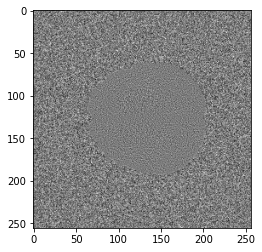

In [25]:
sample = np.load('/home/arunima/diffusion/guided-diffusion/samples_generated/reverse_progress/model_op_[0].npz')
image_1=sample['arr_0']
plt.imshow(image_1.squeeze(),cmap = "gray")

In [21]:
frac = (batch_sigma + 1) / 2
max_log = np.log(betas)
x1 = 1-np.cumprod(alphas)
min_log = np.log(betas*(x1[t-2])/(x1[t-1]))
model_log_variance = frac * max_log[t-1] + (1 - frac) * min_log[t-1]
model_log_variance.shape

NameError: name 'batch_sigma' is not defined

In [ ]:
x_prev  = 1/np.sqrt(alphas[1])*(noisy_batch - (betas[1]/c2)*batch_mu) + model_log_variance*z

In [ ]:
x_p =  x_prev.squeeze().permute(1,2,0).cpu().detach().numpy()
plt.imshow(x_p)